このノートブックでは、与えられたデータセットに関する基本情報を試してみましょう。 このコンペのデータセットは、時間の経過とともに顧客の注文を記述するファイルのリレーショナルセットです。

目的：

コンペの目標は、どの製品がユーザーの次の注文になるかを予測することです。 このデータセットは匿名化されており、Instacartの200,000人以上のInstacartのユーザーから300万件を超える食料品の注文のサンプルを含んでいます。

各ユーザーに対して、4つの注文と100の注文が与えられ、各注文で購入された一連の製品

必要なモジュールをインポートすることから始めましょう。

### 下記のカーネルは各ライブラリをインポートしています

In [3]:
import numpy as np # 線形代数
import pandas as pd # 情報処理, CSV ファイルI/O (例 pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

このコンペにあるファイルをリストアップしましょう。

### 下記のカーネルはcheck_outputメソッドで、データセットのファイルをリストアップしている
subprocessモジュールからcheck_outputメソッドをインポート  
check_output: https://docs.python.jp/3/library/subprocess.html  
decode("utf8"):文字列をUnicode文字列に変換

In [4]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

aisles.csv
aisles.csv.zip
departments.csv
departments.csv.zip
order_products__prior.csv
order_products__prior.csv.zip
order_products__train.csv
order_products__train.csv.zip
orders.csv
orders.csv.zip
products.csv
products.csv.zip
sample_submission.csv
sample_submission.csv.zip



私たちが探索的分析に深く入る前に、与えられたファイルについてもう少し詳しく知りましょう。 よりよく理解するには、最初にすべてのファイルをデータフレームオブジェクトとして読み込み、上の数行を見てみましょう。

 ### 下記のカーネルは６個のCSVファイルを読み込んで各変数に格納し、三つのファイルをheadメソッドで、各々確認表示している

In [5]:
order_products_train_df = pd.read_csv("../input/order_products__train.csv")
order_products_prior_df = pd.read_csv("../input/order_products__prior.csv")
orders_df = pd.read_csv("../input/orders.csv")
products_df = pd.read_csv("../input/products.csv")
aisles_df = pd.read_csv("../input/aisles.csv")
departments_df = pd.read_csv("../input/departments.csv")

In [6]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [8]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


見てわかるように、orders.csvには、注文を購入したユーザー、注文した日、前の注文日などのような、指定した注文IDに関するすべての情報が含まれています。

order_products_trainとorder_products_priorにある列は同じです。次に、これらのファイルの違いは何ですか？

前述のように、このデータセットでは、顧客の4から100のオーダーが与えられます（これについては後で説明します）、再注文される製品を予測する必要があります。ユーザーの最後の注文が取り出され、trainとtestのセットに分けられます。 order_products_priorファイルには、顧客のすべての事前注文情報が含まれています。また、orders.csvファイルにはeval_setというカラムがあることに気づきます。それは、与えられた行が3つのどのデータセット（prior、trainまたはtest）にいくのかを示すカラムです。

Order_products * csvファイルには、再注文された状態とともに与えられた注文で購入された製品に関する詳しい情報があります。

最初に、3つのセットのそれぞれの行の数を取得しましょう。

### 下記のカーネルはorders_dfに含まれるprior、train、testの数をヒストグラムで表示している

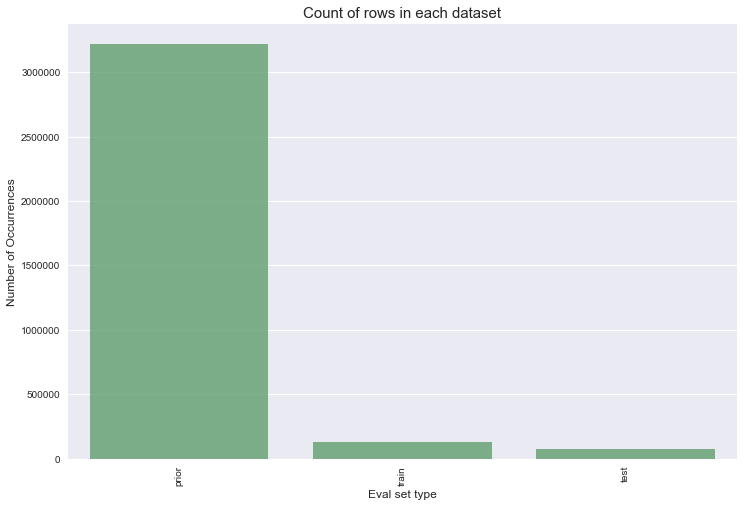

In [8]:
cnt_srs = orders_df.eval_set.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

複数のpriorからtrain testを予測するのでpriorが圧倒的に多い。

### 下記のカーネルはprior, train, testにそれぞれ何人userがいるのか算出している。

orders_dfをeval_setでグループ化し、各グループ内でuser_idを重複無しでcountします。  

aggregate():https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.aggregate.html  

In [12]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

それで合計206,209人の顧客がいる。 そのうち、131,209人の顧客の最後の購入がtrainとして与えられ、残りの75,000人の顧客を予測する必要があります。

今度は、ある顧客の4から100件の注文が与えられたという主張を検証しましょう。

### 下記のカーネルはorders_dfをuser_idでグループ化し、各グループ内でorder_number(注文数)を重複無しでcount。降順で並び替えてインデックスを振り直してヒストグラム表示。

value_counts: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html  


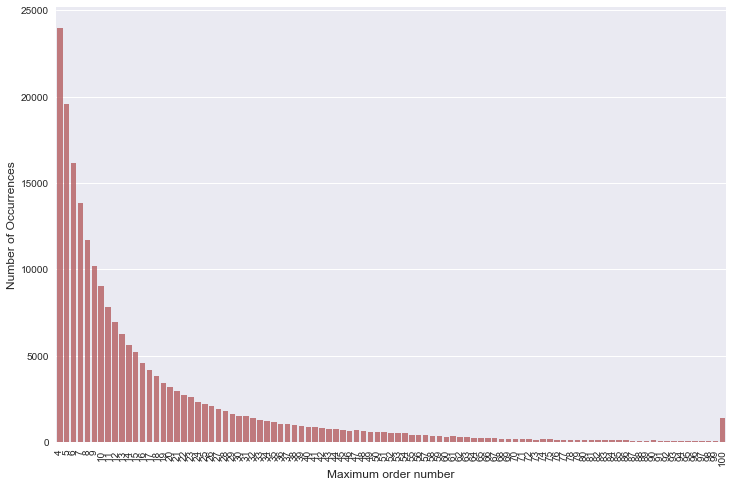

In [13]:
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

したがって、4未満の注文はなく、データページで指定されているように、100で上限になります。

今、注文の習慣が曜日によってどのように変化するかを見てみましょう。

### 下記のカーネルは曜日情報で注文数をヒストグラムで表示

x軸に曜日情報のover_dowをおく。

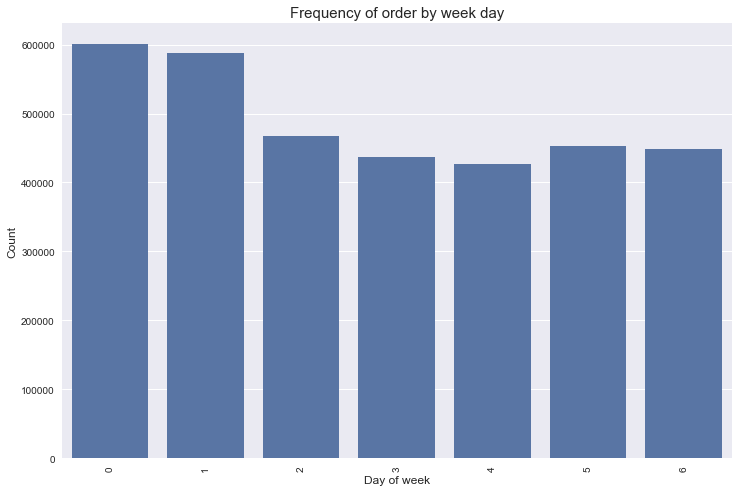

In [14]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders_df, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

注文数が高い０と１がどうやら土曜日と日曜日で、低いのは水曜日ようようです。
今、私たちはその日の時間に関してどのように分布しているかを見るべきです。

###  下記のカーネルは時間に区切って注文数を表示している

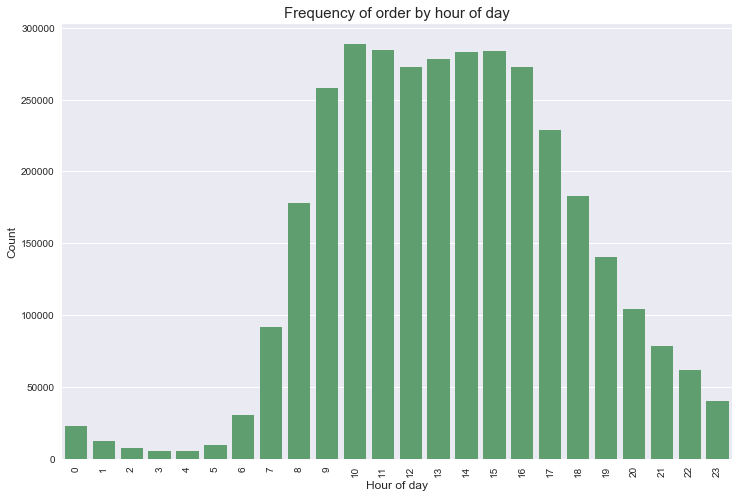

In [9]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

したがって、注文の大半は昼間に行われます。 さて、曜日と時間を組み合わせて分布を見てみましょう。

### 下記のカーネルは各曜日の購入時刻をグループ化し'order_number'を重複無しでカウントし、行を曜日、列を時刻、中身は注文数でピボットテーブルを作成後、ヒートマップで表示。

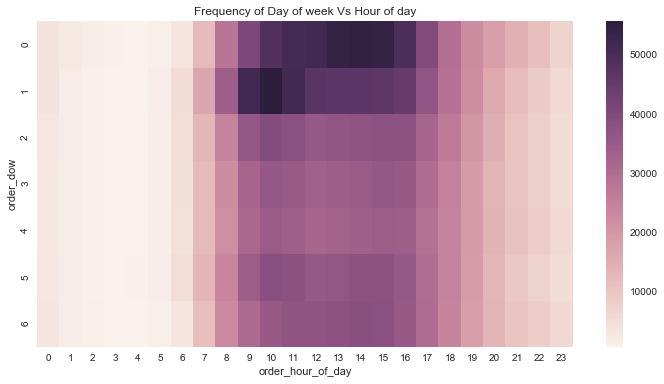

In [16]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

### 土曜日は午後から注文が最大になり、日曜日は午前中の注文が最大になる傾向がある。

土曜日の夕方と日曜日の朝は注文の最期です。
さて、注文間の時間間隔を確認しましょう。

### 下記のカーネルは前回注文してからの日数を集計しヒストグラムで可視化

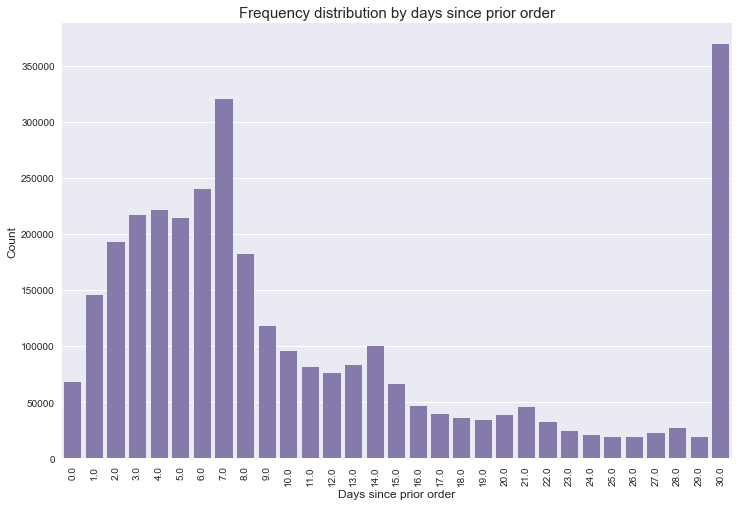

In [17]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

顧客は毎週1回（7日間でピークを確認）、1ヶ月に1回（30日でピーク）のように見えます。 また、14日、21日および28日（週ごとの間隔）でより小さいピークを見ることができた。

私たちの目的は再注文を把握することなので、priorセットと列車trainセットの再注文率をチェックしてみましょう。

### 下記のカーネルはpriorセットの再注文率を算出

In [18]:
# prior set の再注文のパーセンテージ#
order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0]

0.5896974667922161

### 下記のカーネルはtrainセットの再注文率を算出

In [19]:
# rain setの再注文のパーセンテージ#
order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

0.5985944127509629

平均して、オーダー内の製品の約59％が再オーダーされた製品です。

**再注文された商品はありません：**

製品の59％が再注文されたことを確認したので、再注文された商品がない場合もあります。 今すぐ確認しましょう。

### 下記のカーネルはpriorのオーダーのうちの再購入しているオーダーと、再購入していないオーダーを比率を表示

In [20]:
grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].ix[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.879151
0    0.120849
Name: reordered, dtype: float64

再購入していないオーダーは12％

### 下記のカーネルはtrainのオーダーのうちの再購入しているオーダーと、再購入していないオーダーを比率を表示

In [21]:
grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].ix[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.93444
0    0.06556
Name: reordered, dtype: float64

priorセットの注文の約12％は再注文品がありませんが、trainセットでは6.5％です。

さあ、各注文で買った商品の数を見てみましょう。

### 以下のカーネルは各order_idごとの一度の同時注文数の最大値をヒストグラムで表示

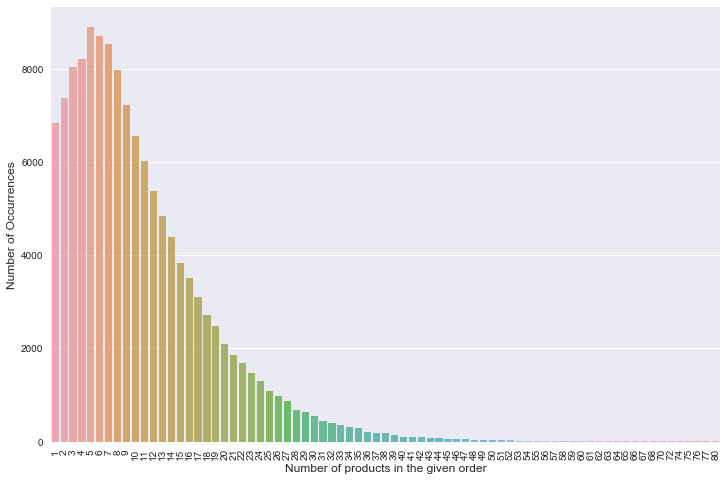

In [22]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

最大値が5の右尾の分布です。

製品の詳細を調べる前に、他の3つのファイルも見てみましょう。

### 下記のカーネルはproducts.csvの上から５行を表示

In [23]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


### 下記のカーネルはaisles.csvの上から５行を表示

In [24]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


### 下記のカーネルはdepartment.csvの上から５行を表示

In [25]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


これらの製品の詳細をorder_priorの詳細とマージしましょう。

### 下記のカーネルはpriorとproduct、aisles、 departmentsの順番に左外部結合しています。

merge(): https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html

In [26]:
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


### 下記のカーネルは最も売れている商品名を販売数とともに降順で表示しています。

In [27]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


おー、それらのほとんどはオーガニックの製品です。 また大部分は果物です。

重要なカテゴリを見てみましょう。

### 下記のカーネルは商品カテゴリ別で売れている順にヒストグラムで表示しています。

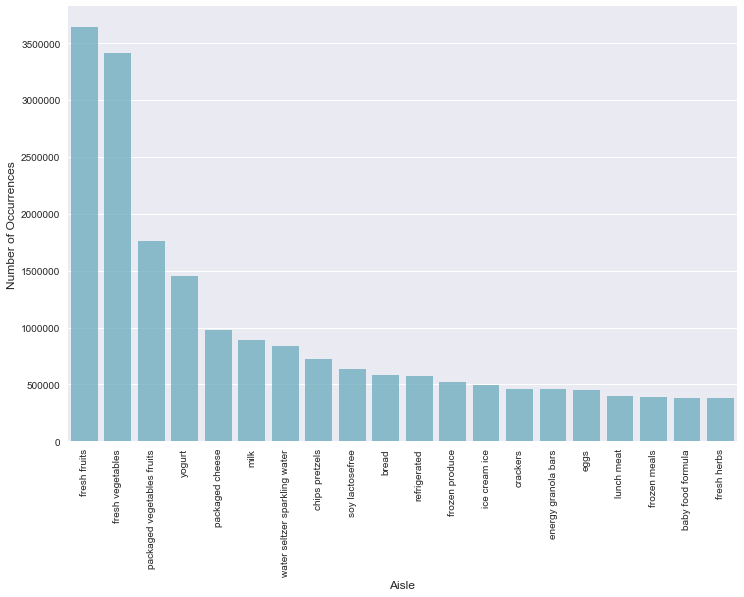

In [28]:
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

上位2つの通路は、新鮮果物と新鮮野菜です。

**部門の配布：**

部門別の賢い分布を確認しましょう。

### 下記のカーネルは販売個数で商品の部門別に円グラフを表示しています。

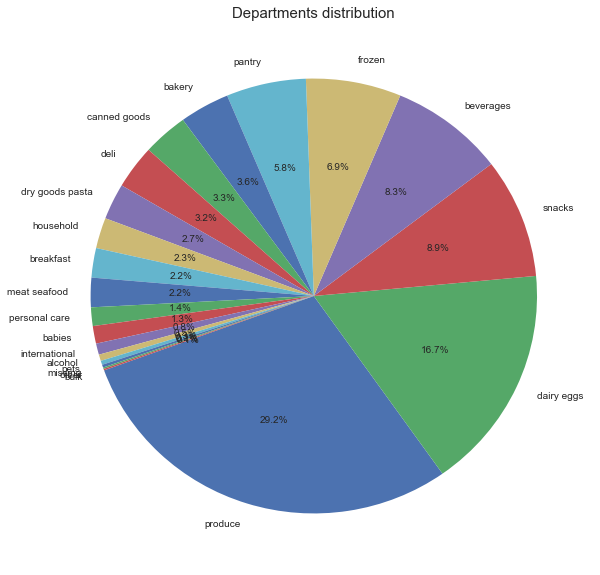

In [39]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

プロデュースは最大の部門です。 さて、各部門の再注文のパーセンテージを確認しましょう。

**部門別再注文率：**

### 下記のカーネルは部門別再注文率を折れ線グラフで表示しています。

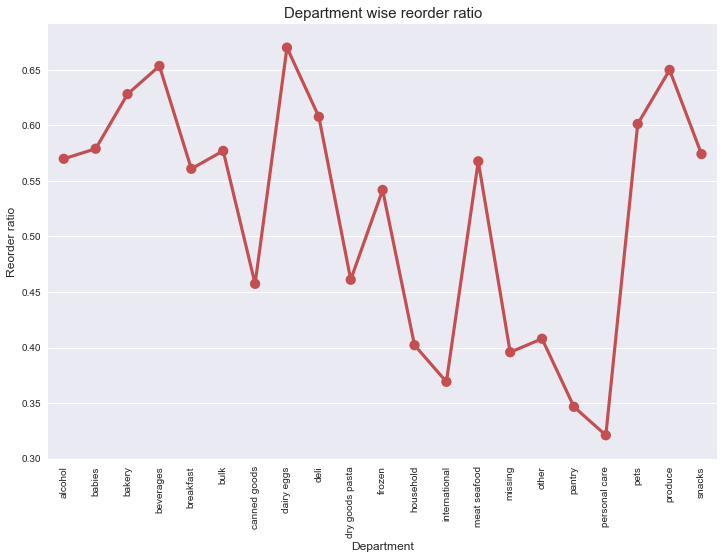

In [30]:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

personal careは再注文率が最も低く、dairy eggsは再注文率が最も高い。

**通路 - 再注文率：**

### 下記のカーネルは部門(department)と商品カテゴリ(aisle)の再購入比率を散布図で表示しています。

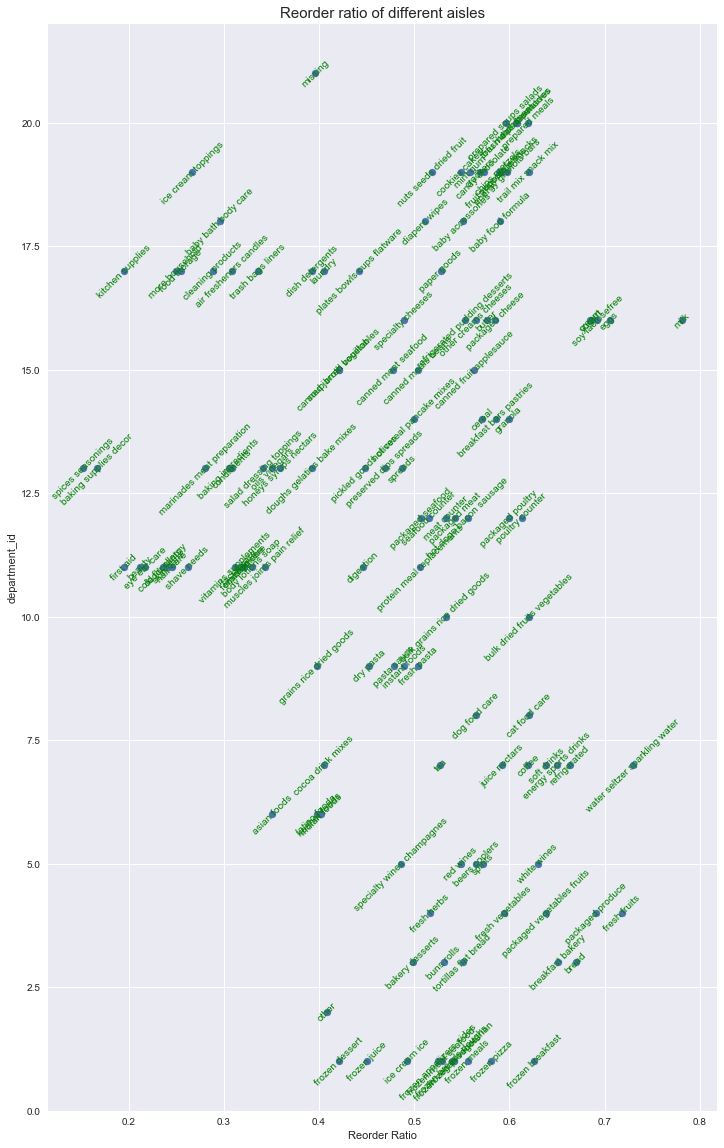

In [32]:
grouped_df = order_products_prior_df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

**カートに入れる - 再注文比率：**

商品のカートへ追加する順番が再注文率にどのように影響するか関係を探りましょう。

### 下記のカーネルは商品をカートに入れる順番と再注文率の関係を表示しています。

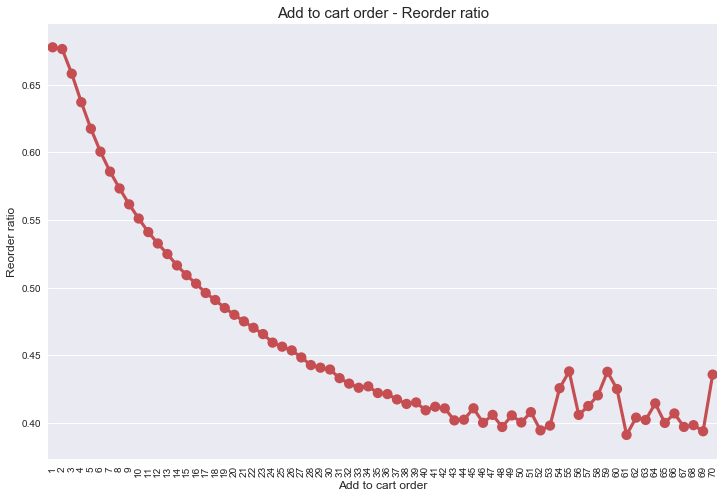

In [33]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df["add_to_cart_order_mod"].ix[order_products_prior_df["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

**カートに最初に追加された商品は、後で追加された商品と比べて、再注文される可能性が高いように見えます。**私は頻繁に購入したことがある商品をすべて最初に注文したあとに、利用可能な新製品を探すという傾向があることから十分に腑に落ちます。

**時間ベース変数による再注文率：**

### 下記のカーネルは曜日ごとの再注文の平均値を棒グラフで表示しています。

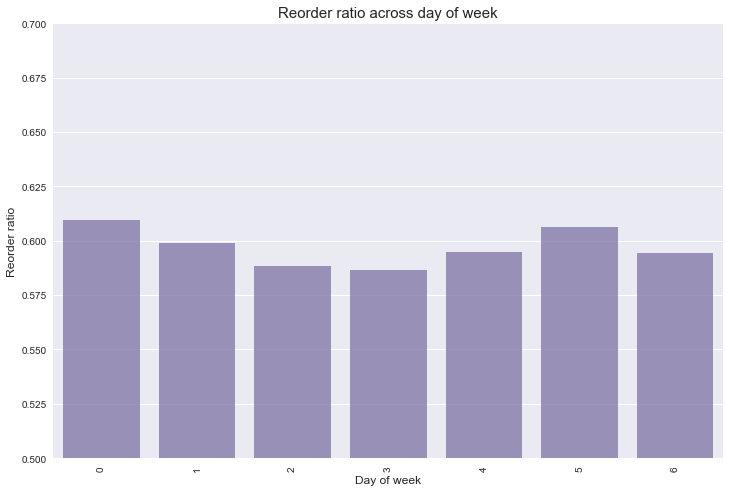

In [10]:
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

特定の曜日で再注文率が大きく変動しているわけではない。

### 下記のカーネルは時刻ごとの再注文の平均値を棒グラフで表示しています。

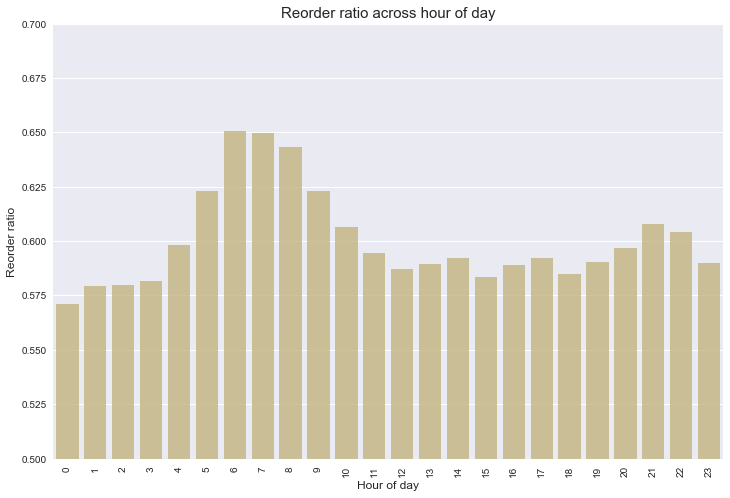

In [35]:
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

In [ ]:
再購入率は朝の時間帯が高いことがわかる。

### 下記のカーネルは縦は曜日、横は時刻、値は再購入率でヒートマップを表示しています。

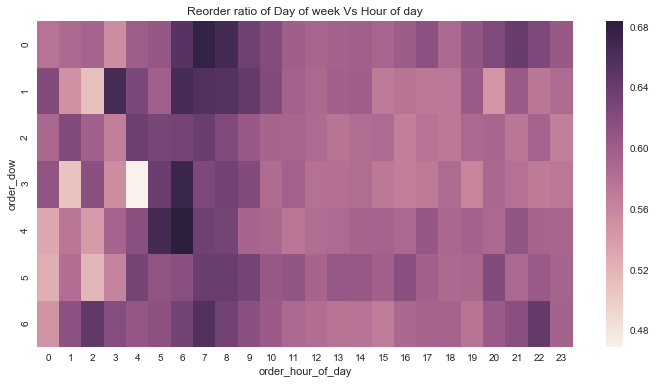

In [38]:
grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)

plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

早朝の再注文率は、その日の後半に比べてかなり高いようです。

**助けてくれることを願っている。 あなたのコメント/提案を残してください。**